As observed in [04_backtest.ipynb](04_backtest.ipynb), the results on cryptocurrencies were not satisfactory. In this notebook, we will explore pairs of ETFs that are more likely to exhibit mean-reverting behaviour. A natural choice is to look at pairs of ETFs that track very similar assets, such as an **Emerging Markets ETF** (EEM) and a **Emerging Markets ex China ETF** (VWO).

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

def fetch_etf(symbol: str,
              start: str = '2018-01-01',
              end:   str = None,
              interval: str = '1d') -> pd.Series:
    df = yf.download(symbol, start=start, end=end, interval=interval, progress=False, auto_adjust=True)
    df = df[['Close']].rename(columns={'Close': symbol})
    return df[symbol]

def get_etf_pair(symbol_a: str,
                 symbol_b: str,
                 start: str = '2018-01-01',
                 end:   str = None,
                 interval: str = '1d') -> pd.DataFrame:
    a = fetch_etf(symbol_a, start=start, end=end, interval=interval)
    b = fetch_etf(symbol_b, start=start, end=end, interval=interval)
    return pd.concat([a, b], axis=1).dropna()

In [2]:
symbol_a = 'EEM'
symbol_b = 'VWO'
data = get_etf_pair(symbol_a, symbol_b, start='2018-01-01', interval='1d')

Total PnL: 3.04
Annualized Sharpe: 0.95
Max Drawdown: -0.20


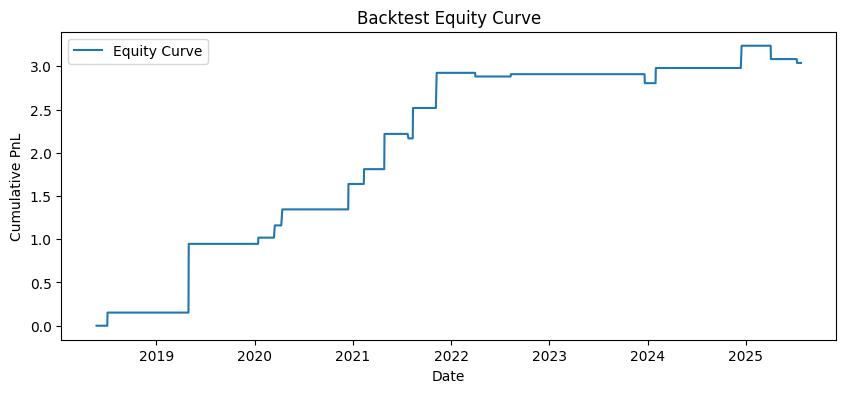

In [3]:
rolling_window = 50
entry_threshold = 2.5
exit_threshold = 0.05


y = data[symbol_a]
X = sm.add_constant(data[symbol_b])
rols = RollingOLS(y, X, window=rolling_window)
model = rols.fit()
data['alpha']    = model.params['const']
data['beta']     = model.params[symbol_b]
data['residual'] = data[symbol_a] - (data['alpha'] + data['beta'] * data[symbol_b])

data['mean_res'] = data['residual'].rolling(window=rolling_window).mean()
data['std_res']  = data['residual'].rolling(window=rolling_window).std()
data['z_score']  = (data['residual'] - data['mean_res']) / data['std_res']

data = data.dropna(subset=['alpha','beta','residual','z_score'])

# setup backtesting
data['position'] = 0 # +1 = long spread, -1 = short spread, 0 = neutral
data['a_pos'] = 0.0
data['b_pos'] = 0.0
data['pnl'] = 0.0

def size_positions(price_a, price_b, beta=1.0):
    size_a = 1.0
    size_b = price_a / price_b * size_a * beta
    return size_a, size_b

state    = 'neutral'
entry_pa = entry_pb = 0.0
stop_loss_pct = 0.1

for idx, row in data.iterrows():
    z    = row['z_score']
    pa   = row[symbol_a]
    pb   = row[symbol_b]
    hb   = row['beta']      # use the day-t hedge ratio
    

    if state == 'neutral':
        if z <= -entry_threshold:
            # Long spread: buy A, sell B
            sa, sb = size_positions(pa, pb)
            entry_pa, entry_pb = pa, pb
            data.at[idx,'a_pos']    =  sa
            data.at[idx,'b_pos']    = -sb
            data.at[idx,'position'] =  1
            state = 'long'

        elif z >= entry_threshold:
            # Short spread: sell A, buy B
            sa, sb = size_positions(pa, pb)
            entry_pa, entry_pb = pa, pb
            data.at[idx,'a_pos']    = -sa
            data.at[idx,'b_pos']    =  sb
            data.at[idx,'position'] = -1
            state = 'short'
        # else remain flat (positions already zeroed)

    else:
        # carry forward the positions
        prev = data.loc[:idx].iloc[-2]
        data.at[idx,'a_pos']    = prev['a_pos']
        data.at[idx,'b_pos']    = prev['b_pos']
        data.at[idx,'position'] = 1 if state=='long' else -1

        sign =  1 if state=='long' else -1
        pnl_pct_A = sign * (pa - entry_pa) / entry_pa
        pnl_pct_B = sign * (entry_pb - pb)  / entry_pb  # B is inverse leg

        # 2a) Normal exit on mean-reversion
        if abs(z) < exit_threshold:
            exit_reason = 'z_exit'
        # 2b) Stop-loss exit if either leg has lost > stop_loss_pct
        elif (pnl_pct_A < -stop_loss_pct) or (pnl_pct_B < -stop_loss_pct):
            exit_reason = 'stop_loss'
        else:
            exit_reason = None

        if exit_reason:
            # book PnL
            pnl_A = (pa - entry_pa) * prev['a_pos']
            pnl_B = (pb - entry_pb) * prev['b_pos']
            data.at[idx,'pnl'] = pnl_A + pnl_B

            # reset
            data.at[idx,'a_pos']    = 0.0
            data.at[idx,'b_pos']    = 0.0
            data.at[idx,'position'] = 0
            state = 'neutral'
            data.at[idx,'exit_reason'] = exit_reason
            
data['cum_pnl'] = data['pnl'].cumsum()
total_return = data['cum_pnl'].iat[-1]
sharpe = data['pnl'].mean() / data['pnl'].std() * np.sqrt(252)
max_dd = (data['cum_pnl'] - data['cum_pnl'].cummax()).min()

print(f"Total PnL: {total_return:.2f}")
print(f"Annualized Sharpe: {sharpe:.2f}")
print(f"Max Drawdown: {max_dd:.2f}")

plt.figure(figsize=(10, 4))
plt.plot(data.index, data['cum_pnl'], label='Equity Curve')
plt.title('Backtest Equity Curve')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.show()


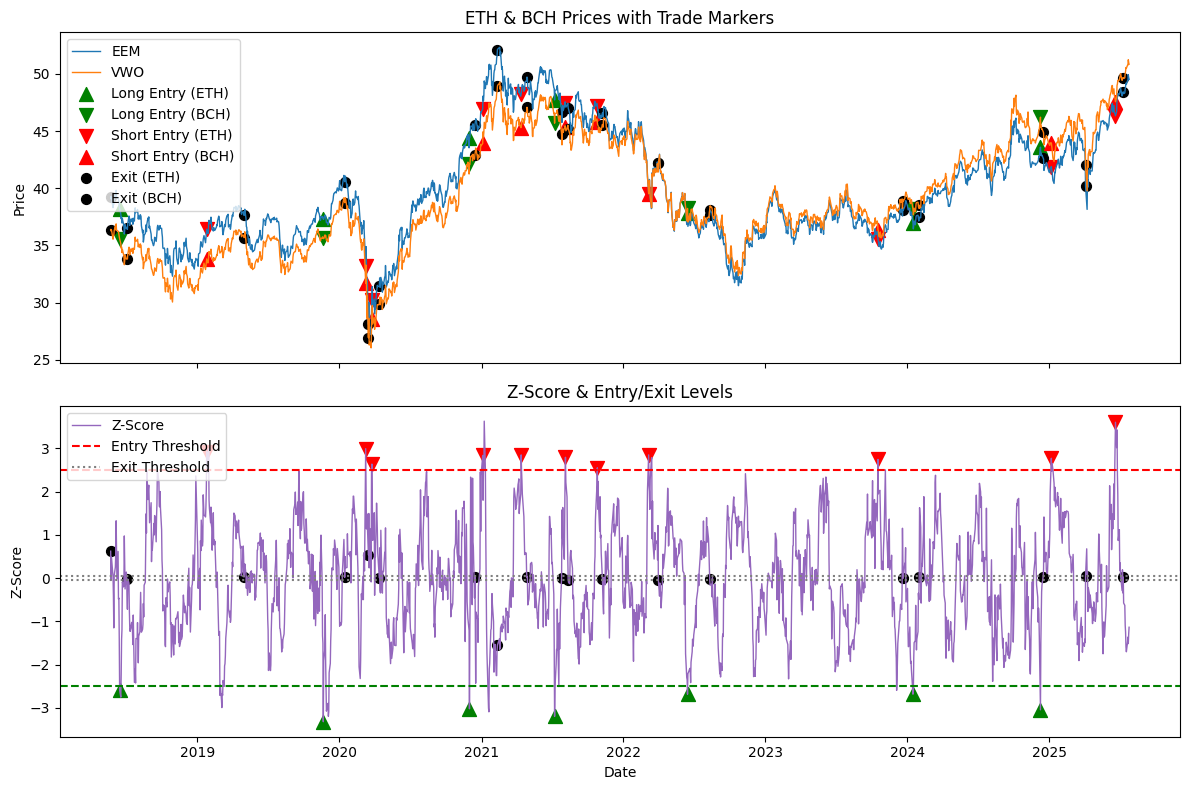

In [4]:
import matplotlib.pyplot as plt

long_entries  = data[(data['position'] == 1)  & (data['position'].shift(1) == 0)]
short_entries = data[(data['position'] == -1) & (data['position'].shift(1) == 0)]
exits         = data[(data['position'] == 0)  & (data['position'].shift(1) != 0)]

fig, (ax_price, ax_z) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax_price.plot(data.index, data[symbol_a], label=symbol_a, lw=1)
ax_price.plot(data.index, data[symbol_b], label=symbol_b, lw=1)

ax_price.scatter(long_entries.index,  long_entries[symbol_a],
                 marker='^', color='green',  s=100, label='Long Entry (ETH)')
ax_price.scatter(long_entries.index,  long_entries[symbol_b],
                 marker='v', color='green',  s=100, label='Long Entry (BCH)')

ax_price.scatter(short_entries.index, short_entries[symbol_a],
                 marker='v', color='red',    s=100, label='Short Entry (ETH)')
ax_price.scatter(short_entries.index, short_entries[symbol_b],
                 marker='^', color='red',    s=100, label='Short Entry (BCH)')

ax_price.scatter(exits.index, exits[symbol_a],
                 marker='o', color='black', s=50, label='Exit (ETH)')
ax_price.scatter(exits.index, exits[symbol_b],
                 marker='o', color='black', s=50, label='Exit (BCH)')

ax_price.set_ylabel("Price")
ax_price.legend(loc='upper left')
ax_price.set_title("ETH & BCH Prices with Trade Markers")

ax_z.plot(data.index, data['z_score'], label='Z-Score', lw=1, color='C4')
ax_z.axhline(entry_threshold, color='red',   linestyle='--', label='Entry Threshold')
ax_z.axhline(-entry_threshold, color='green', linestyle='--')
ax_z.axhline(exit_threshold, color='gray',   linestyle=':', label='Exit Threshold')
ax_z.axhline(-exit_threshold, color='gray',  linestyle=':')

ax_z.scatter(long_entries.index,  long_entries['z_score'],
             marker='^', color='green', s=100)
ax_z.scatter(short_entries.index, short_entries['z_score'],
             marker='v', color='red',   s=100)
ax_z.scatter(exits.index, exits['z_score'],
             marker='o', color='black', s=50)

ax_z.set_ylabel("Z-Score")
ax_z.legend(loc='upper left')
ax_z.set_title("Z-Score & Entry/Exit Levels")

plt.xlabel("Date")
plt.tight_layout()
plt.show()

We observe that the results here look much better. We will therefore now compare the strategy to just investing in a simple equal-weighted portfolio of the two ETFs. 

In [5]:
ret_a = data[symbol_a].pct_change().dropna()
ret_b = data[symbol_b].pct_change().dropna()

returns = pd.concat([ret_a, ret_b], axis=1, join='inner')
returns['ew_portfolio'] = 0.5 * returns[symbol_a] + 0.5 * returns[symbol_b]

daily_mean = returns['ew_portfolio'].mean()
daily_std  = returns['ew_portfolio'].std()
sharpe     = daily_mean / daily_std * np.sqrt(252)

print(f"Equal-Weighted {symbol_a}, {symbol_b} Portfolio Annualized Sharpe: {sharpe:.2f}")

Equal-Weighted EEM, VWO Portfolio Annualized Sharpe: 0.30


In [18]:
symbol_a, symbol_b = 'EEM', 'VWO'      # change if you test another pair

# strategy metrics
# max drawdown
strat_dd = data['cum_pnl'] - data['cum_pnl'].cummax()
max_dd_strat = strat_dd.min()

# % of days invested
pct_days_invested = (data['position'] != 0).mean() * 100

# Sharpe during invested days only
data['daily_ret'] = data['cum_pnl'].diff().fillna(0)

invested_mask = data['position'].shift(1) != 0 # shift because PnL comes one day after investment is exited
invested_returns = data.loc[invested_mask, 'daily_ret']

sharpe_invested = invested_returns.mean() / invested_returns.std() * np.sqrt(252)

# 50-50 portfolio metrics
ret_a = data[symbol_a].pct_change()
ret_b = data[symbol_b].pct_change()
ew_ret = 0.5 * (ret_a + ret_b)
ew_ret = ew_ret.dropna()

cum_ew = (1 + ew_ret).cumprod() - 1
ew_dd = cum_ew - cum_ew.cummax()
max_dd_ew = ew_dd.min()

sharpe_ew = ew_ret.mean() / ew_ret.std() * np.sqrt(252)

metrics = pd.DataFrame({
    'Max Drawdown':      [max_dd_strat, max_dd_ew],
    'Time Invested (%)': [pct_days_invested, 100.0],
    'Sharpe (Invested)': [sharpe_invested, sharpe_ew]
}, index=['Strategy', 'Equal-Weighted'])

display(metrics)

,Max Drawdown,Time Invested (%),Sharpe (Invested)
Strategy,-0.198789,22.185247,2.032839
Equal-Weighted,-0.498711,100.000000,0.295593


We observe that out strategy outperforms the equal-weighted portfolio in all metrics. Hence we continue to implement the strategy now.